# Fraud Detection Analysis

## Dataset Description
The dataset represents simulated financial transactions over a period of 30 days (744 hours). Each row corresponds to a single transaction, with attributes capturing transaction details, account balances, and fraud indicators.

### Column Description
- **step**: Time index in hours (1 step = 1 hour).
- **type**: Transaction type (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER).
- **amount**: Transaction amount in local currency.
- **nameOrig / nameDest**: Origin and destination account identifiers.
- **oldbalanceOrg / newbalanceOrig**: Origin account balance before and after transaction.
- **oldbalanceDest / newbalanceDest**: Destination account balance before and after transaction.
- **isFraud**: Target variable indicating fraudulent transactions.
- **isFlaggedFraud**: Rule-based fraud flag for large transfers (>200,000).



### Notes on Data Characteristics
- The dataset is highly imbalanced, with fraud representing a very small fraction of transactions.
- Missing destination balances are expected for merchant accounts.
- Balance-related features exhibit multicollinearity, which was addressed during feature engineering.


### Data Loading and Initial Exploration
This section imports the required Python libraries and loads the dataset. An initial exploration is performed to understand the data structure, variable types, and sample records before proceeding with preprocessing and modeling.



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/drive/MyDrive/Aditya/Data/Fraud.csv")

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## 1. Data Cleaning & Feature Engineering
This section focuses on preparing the dataset for modeling by handling missing values, addressing class imbalance, removing non-informative identifiers, reducing multicollinearity, and engineering meaningful features that capture transactional and temporal behavior relevant to fraud detection.

### **Missing Values & Class Distribution**
Missing values were examined across all variables. The target variable (`isFraud`) was analyzed to understand the degree of class imbalance, revealing a highly imbalanced dataset with fraud representing a very small fraction of transactions.


### **Removal of Non-Predictive Identifiers**
Customer identifiers (`nameOrig`, `nameDest`) were removed as they are unique IDs and do not provide generalizable patterns for fraud prediction.


### **Balance-Based Feature Engineering & Multicollinearity Reduction**
Strong multicollinearity was observed among balance-related variables. To address this, balance change features were engineered to capture the net effect of transactions on both origin and destination accounts. The original balance columns were then dropped to avoid redundancy.


### **Temporal Feature Engineering**
Time-based features were derived from the transaction timestamp to capture temporal fraud patterns. The `step` variable was decomposed into `hour` of day and `day` of simulation, after which the original `step` column was removed.

In [7]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [8]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [9]:
df.drop(columns=["nameOrig", "nameDest"], inplace=True)

In [10]:
df["orig_balance_change"] = df["oldbalanceOrg"] - df["newbalanceOrig"]

In [11]:
df["dest_balance_change"] = df["newbalanceDest"] - df["oldbalanceDest"]

In [12]:
df.drop(
    columns=[
        "oldbalanceOrg",
        "newbalanceOrig",
        "oldbalanceDest",
        "newbalanceDest"
    ],
    inplace=True
)

In [13]:
df["hour"] = df["step"] % 24
df["day"] = df["step"] // 24
df.drop(columns=["step"], inplace=True)

## Baseline Model: Logistic Regression

Logistic Regression was implemented as a baseline model due to its simplicity, interpretability, and common use in fraud detection. The target variable was separated, categorical features were one-hot encoded, and a stratified train–test split was applied to preserve class imbalance.

To address the extreme imbalance, class weights and feature scaling were used. Model robustness was evaluated by testing multiple regularization strengths (`C`) and probability thresholds. Performance was measured using precision, recall, and F1-score rather than accuracy.

While the model achieved high recall, precision remained relatively low compared to tree-based approaches. Therefore, Logistic Regression was retained as a baseline reference but not selected as the final model.


In [14]:
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

In [15]:
X= pd.get_dummies(X, columns=["type"], drop_first=True)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [22]:
from sklearn.metrics import classification_report
for C in [0.01, 0.1, 1, 10]:
    model = LogisticRegression(
        C=C,
        max_iter=1000,
        class_weight="balanced"
    )
    model.fit(X_train, y_train)

    y_probs = model.predict_proba(X_test)[:, 1]
    for t in [0.80,0.90]:
      y_pred = (y_probs >= t).astype(int)
      print(f"\nC = {C}\nThreshold = {t}")
      print(classification_report(y_test, y_pred))



C = 0.01
Threshold = 0.8
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270881
           1       0.08      0.89      0.14      1643

    accuracy                           0.99   1272524
   macro avg       0.54      0.94      0.57   1272524
weighted avg       1.00      0.99      0.99   1272524


C = 0.01
Threshold = 0.9
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.14      0.83      0.24      1643

    accuracy                           0.99   1272524
   macro avg       0.57      0.91      0.62   1272524
weighted avg       1.00      0.99      1.00   1272524


C = 0.1
Threshold = 0.8
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270881
           1       0.08      0.89      0.14      1643

    accuracy                           0.99   1272524
   macro avg       0.54      0.94      0.57   12725

### Logistic Regression – Results Summary

Logistic Regression was used as a baseline model and evaluated across multiple regularization strengths and probability thresholds. Model performance was largely insensitive to changes in `C`. While high recall was achieved for fraudulent transactions, precision remained consistently low even at higher thresholds, resulting in excessive false positives. Therefore, Logistic Regression was not selected as the final model but retained as a baseline for comparison.


## Decision Tree Model

The dataset was split into training and test sets using a stratified approach to preserve the original fraud distribution. Class imbalance was explicitly handled using custom class weights to penalize misclassification of fraudulent transactions more heavily.

A Decision Tree classifier was trained with controlled depth, minimum leaf size, and cost-complexity pruning to reduce overfitting while capturing non-linear fraud patterns. Model performance was evaluated using probability threshold tuning to analyze the precision–recall trade-off, which is critical in fraud detection scenarios.

Results show that lower thresholds favor higher recall, while higher thresholds significantly improve precision at the cost of recall. This flexibility allows the model to be adapted based on business priorities. Train and test performance were compared to ensure the model generalizes well and does not overfit.


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [24]:
df.head()
df.columns

Index(['type', 'amount', 'isFraud', 'isFlaggedFraud', 'orig_balance_change',
       'dest_balance_change', 'hour', 'day'],
      dtype='object')

In [25]:
y.value_counts(normalize=True)

,proportion
isFraud,
0,0.998709
1,0.001291


In [26]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42,class_weight = {0: 1, 1: 15},
                              max_depth=8,
                              ccp_alpha = 0.0001,
                              min_samples_leaf=300 )
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight={0: 1, 1: 15},
                       max_depth=8, min_samples_leaf=300, random_state=42)

In [29]:
from sklearn.metrics import classification_report

y_train_pred = tree.predict(X_train)
y_test_pred  = tree.predict(X_test)

print("TRAIN:")
print(classification_report(y_train, y_train_pred))

print("TEST:")
print(classification_report(y_test, y_test_pred))


TRAIN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083526
           1       0.42      0.83      0.56      6570

    accuracy                           1.00   5090096
   macro avg       0.71      0.92      0.78   5090096
weighted avg       1.00      1.00      1.00   5090096

TEST:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.42      0.82      0.56      1643

    accuracy                           1.00   1272524
   macro avg       0.71      0.91      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524



In [27]:
y_probs = tree.predict_proba(X_test)[:, 1]

for t in [0.4,0.5,0.6,0.7, 0.8, 0.9, 0.95]:
    y_pred = (y_probs >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred))



Threshold = 0.4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.42      0.82      0.56      1643

    accuracy                           1.00   1272524
   macro avg       0.71      0.91      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524


Threshold = 0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.42      0.82      0.56      1643

    accuracy                           1.00   1272524
   macro avg       0.71      0.91      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524


Threshold = 0.6
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.45      0.81      0.58      1643

    accuracy                           1.00   1272524
   macro avg       0.73      0.90      0.79   1272524
weighted avg       1.00

Based on the results, higher thresholds provide cleaner fraud alerts, while lower thresholds prioritize fraud recall, enabling threshold selection based on business risk tolerance.


## Final Model: Gradient Boosted Trees (LightGBM)

After evaluating multiple models, a Gradient Boosted Tree model (LightGBM) was selected as the final fraud detection model. LightGBM was chosen due to its ability to capture complex non-linear relationships, handle large-scale tabular data efficiently, and perform well on highly imbalanced datasets.

The model was trained using class weights to emphasize fraudulent transactions and controlled tree complexity to prevent overfitting. Probability threshold tuning was applied to analyze the precision–recall trade-off, which is critical in fraud detection scenarios where missing fraud can be more costly than false alarms.

Compared to Logistic Regression and a single Decision Tree, LightGBM achieved a significantly better balance between precision and recall. At a threshold of 0.6, the model demonstrated strong generalization with similar performance on both training and test data, indicating robust and stable behavior.


In [30]:
import lightgbm as lgb
from sklearn.metrics import classification_report

lgbm = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight={0: 1, 1: 15},
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6570, number of negative: 5083526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.443402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019017 -> initscore=-3.943196
[LightGBM] [Info] Start training from score -3.943196


LGBMClassifier(class_weight={0: 1, 1: 15}, colsample_bytree=0.8,
               learning_rate=0.05, max_depth=8, n_estimators=200, n_jobs=-1,
               num_leaves=64, random_state=42, subsample=0.8)

### Performance Demonstration
We demonstrate performance using Precision, Recall, and F1-score. In fraud detection, **Precision** is key (we don't want to flag legal customers as fraud), but **Recall** is also critical (we don't want to miss actual fraud).

In [31]:
y_probs = lgbm.predict_proba(X_test)[:, 1]

for t in [0.4, 0.5, 0.6, 0.7, 0.8]:
    y_pred = (y_probs >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred))


Threshold = 0.4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.65      0.87      0.74      1643

    accuracy                           1.00   1272524
   macro avg       0.82      0.93      0.87   1272524
weighted avg       1.00      1.00      1.00   1272524


Threshold = 0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.74      0.86      0.80      1643

    accuracy                           1.00   1272524
   macro avg       0.87      0.93      0.90   1272524
weighted avg       1.00      1.00      1.00   1272524


Threshold = 0.6
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.81      0.85      0.83      1643

    accuracy                           1.00   1272524
   macro avg       0.91      0.92      0.92   1272524
weighted avg       1.00

### Key Factors

1.  `day` / `hour`: Time of transaction.
2.  `dest_balance_change`: How much the destination account changed.
3.  `amount`: The value of the transaction.
4.  `orig_balance_change`: How much the origin account changed.


In [32]:
import pandas as pd

imp = pd.Series(
    lgbm.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print(imp.head(10))

day                    2576
hour                   2514
dest_balance_change    2368
amount                 2284
orig_balance_change    1844
type_CASH_OUT           410
type_TRANSFER           271
type_PAYMENT            223
isFlaggedFraud           81
type_DEBIT               29
dtype: int32


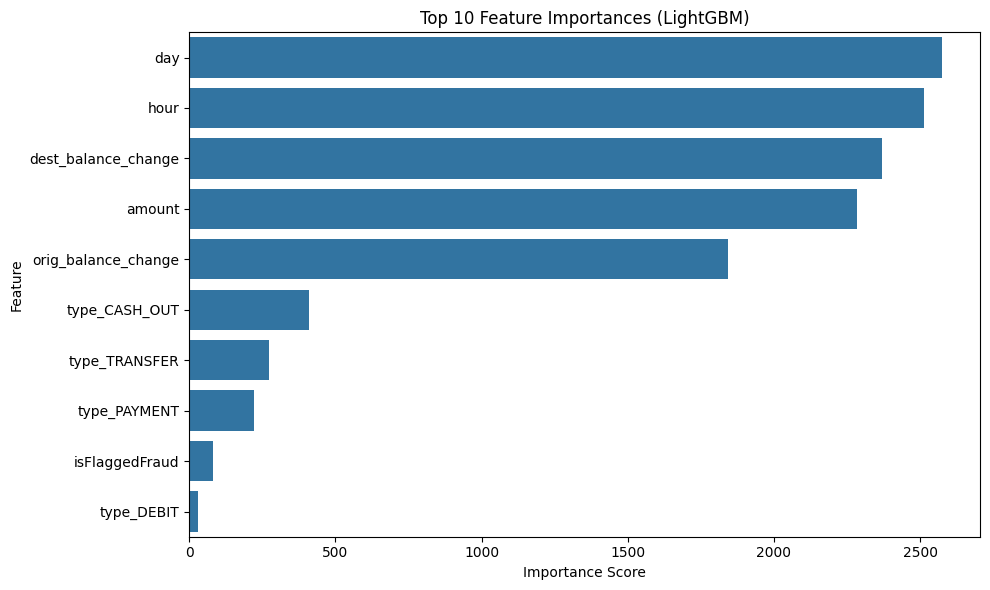

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

top_imp=imp.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_imp.values, y=imp.index)
plt.title("Top 10 Feature Importances (LightGBM)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import classification_report

print("TRAIN")
print(classification_report(y_train, (lgbm.predict_proba(X_train)[:,1] >= 0.6).astype(int)))

print("TEST")
print(classification_report(y_test, (lgbm.predict_proba(X_test)[:,1] >= 0.6).astype(int)))


TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083526
           1       0.84      0.88      0.86      6570

    accuracy                           1.00   5090096
   macro avg       0.92      0.94      0.93   5090096
weighted avg       1.00      1.00      1.00   5090096

TEST
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.81      0.85      0.83      1643

    accuracy                           1.00   1272524
   macro avg       0.91      0.92      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524



### Model Selection Rationale

LightGBM was selected as the final model because it consistently outperformed baseline and tree-based models across key evaluation metrics. The model achieved high recall while maintaining strong precision, resulting in a superior F1-score. Additionally, minimal performance gap between training and test sets suggests limited overfitting and good generalization, making the model suitable for real-world fraud detection.

The close alignment between training and test performance confirms that the model does not memorize the data and generalizes well to unseen transactions.


### Conclusion and Recommendations
#### Prevention Strategies
While updating infrastructure, the company should adopt:
*   **Real-time Monitoring**: Implement the LightGBM model to score transactions in real-time. If probability > 0.6 (our tuned threshold), flag for manual review or MFA (Multi-Factor Authentication).
*   **Velocity Checks**: Add rules to flag multiple high-value transfers in a short `hour` span, as our model identified time as a key factor.
*   **Balance Monitoring**: Trigger alerts if an account balance drops to near zero immediately after a large transaction (`orig_balance_change` approx equal to `amount`).

#### Verification of Actions
To determine if these actions work:
*   **A/B Testing**: Run the model in "shadow mode" (flagging but not blocking) on a subnet of users and compare fraud rates against the blocked control group.
*   **False Positive Rate Tracking**: Monitor customer complaints. If valid transactions are blocked often, retrain with adjusted class weights.
*   **Financial Saving Metric**: Calculate `(Total Value of Fraud Prevented) - (Operational Cost of Model)` to quantify ROI.